## Implement Naive Bayes Without Library

<span style='font-family:B Nazanin'>
در طبقه بند optimal ما correlation که بین ویژگی ها وجود دارد را در نظر می گیریم. از آنجا که این کار در ابعاد بالا ممکن نیست و باعث پیچیده شدن آن می شود٬ در نتیجه همه ویژگی ها را مستقل در نظر میگیریم در این صورت در فرمول بیز٬ احتمال هر کدام در هم ضرب می شود و اینکار را برای ما بسیار ساده می کند. به دلیل پیچیده شدن مسئله از پیاده سازی optimal اجتناب می کنیم.   
   <br>
    <br>
    الف)
    
</span>

In [40]:
import numpy as np 
import pandas as pd

In [41]:
breast= pd.read_csv('Data/Breast_cancer_data.csv')
breast


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


<span style='font-family:B Nazanin'>
    داده های مورد نظر را از فایل خوانده و در breast قرار می دهیم. سپس ۷۰ درصد داده ها را برای train و بقیه را برای test مدل نگه می داریم. ستون آخر که شامل مقدار واقعی label ها می باشد را جدا کرده و در متغیر y برای هر دو دسته قرار می دهیم.
    </span>

In [42]:
train = breast.sample(frac=0.7, random_state= 1).reset_index(drop=True)
test = breast.drop(train.index).reset_index(drop=True)

y_train = train['diagnosis']
x_train = train.drop('diagnosis', axis = 1)

y_test = test['diagnosis']
x_test = test.drop('diagnosis', axis = 1)


<span style='font-family:B Nazanin'>
مقدار میانگین و انحراف از معیار را بر اساس داده های train برای هر یک از ویژگی ها به دست می آوریم. سپس کلاس هایی که وجود دارند را از دیتا استخراج کرده و برای هر کدام مقدار prior را محاسبه می کنیم.    
</span>

In [43]:
means = train.groupby('diagnosis').mean()
means

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
diagnosis,,,,,
0,17.406779,21.373154,115.018725,970.490604,0.103011
1,12.263594,17.948434,78.853373,471.618876,0.092412


In [44]:
var = train.groupby('diagnosis').var()
var

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
diagnosis,,,,,
0,9.600704,13.592562,440.403314,118045.587884,0.000177
1,3.247434,14.600425,145.167931,18327.475408,0.000186


In [45]:
prior = (train.groupby('diagnosis').count()/len(train)).iloc[:,1]
prior

diagnosis
0    0.374372
1    0.625628
Name: mean_texture, dtype: float64

In [46]:
classes = np.unique(train['diagnosis'])
classes

array([0, 1])

<span style = 'font-family: B Nazanin'>
    از تابع normal برای محاسبه likelihood استفاده می کنیم :
    </span>

![image](https://miro.medium.com/max/1024/1*6h77xJ0Wd5xt8E2LPAi5PA.png)

In [47]:
def Normal(x, mean, var):
    sd = np.sqrt(var)
    pdf = (np.e ** (-0.5 * ((x - mean)/sd) ** 2) / (sd * np.sqrt(2 * np.pi)))
    
    return pdf

<span style='font-family:B Nazanin'>
    در تابع predict فرایند زیر را برای هر sample انجام می دهیم :
    <br>
    <br>
    １.	به ازای هر ویژگی٬ کار های زیر را انجام می دهیم :
    <br>
    <br>
    a.	مقدار میانگین و انحراف از معیار را از دو متغیر means و var که در بالا محاسبه شد٫ استخراج می کنیم.
    <br>
    b.	مقدار likelihood را با استفاده از تابع normal محاسبه می کنیم. (برای راحتی کار مقدار log را در نهایت به دست می آوردیم) در صورتی که مقدار likelihood برابر صفر باشد برای جلوگیری از صفر شدن کل احتمال آن را برابر با مقداری ناچیز قرار می دهیم.
    <br>
    <br>
    2. حال همه مقادیر را با هم جمع کرده و مقدار prior را هم به آن اضافه می کنیم.
    <br>
    <br>
    ３.	از بین مقادیر به دست آمده بیشتری مقدار را انتخاب می کنیم و label مربوطه را به نمونه خود اختصاص می دهیم.
</span>

![image](https://miro.medium.com/max/1400/1*8-DZUh-6xdqD-P9zXAJblA.png)

In [48]:
def Predict(info):

    predictions = []
    
    # Loop for each row data
    for item in info.index:
        
        class_likelihood = []
        instance = info.loc[item]
        
        # Loop for each class
        for cls in classes:
            
            feature_likelihood = []
            
            # Calculate log(P(C)) or log(Prior)
            
            feature_likelihood.append(np.log(prior[cls]))
            
            # Loop for each feature
            for col in x_train.columns:
                
                data = instance[col]
                
                # Find mean column in class cls
                mean = means[col].loc[cls]
                
                # Find variance column in class cls
                variance = var[col].loc[cls]
                
                likelihood = Normal(data, mean, variance)
                
                if likelihood != 0:
                    
                    #Calculate log Likelihood
                    likelihood = np.log(likelihood)
                else:
                    # if value likelihood = 0 , we consider value of 1/length(train) (small amount)
                    likelihood = 1/len(train)
                
                feature_likelihood.append(likelihood)
             
            # Calulate Posterior
            total_likelihood = sum(feature_likelihood)
            class_likelihood.append(total_likelihood)
        
        # Find the best class for instance
        maxIndex = class_likelihood.index(max(class_likelihood))
        prediction = classes[maxIndex]
        predictions.append(prediction)
        
    return predictions
            
                
                
        

In [49]:
predict_train = Predict(x_train) 
predict_test = Predict(x_test)


<span style='font-family:B Nazanin'>
    ب)
      </span>

<span style='font-family:B Nazanin'>
    مقدار accuracy را مطابق فرمول زیر محاسبه می کنیم و همان طور که مشاهده می کنید بر روی داده های test دقت بسیار خوبی دار.
    </span>

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/f0453f2614cd29f5dd49c2c9a0ef807985128e9e)

## Accuracy

In [53]:
def Accuracy(y, prediction):
    y = np.array(y)
    prediction = np.array(prediction)
    true_predict = np.where(prediction == y, 1, 0)
    
    return (round(true_predict.sum()/len(true_predict), 4))*100
    

In [54]:
Accuracy(y_test, predict_test)

94.15

<span style='font-family:B Nazanin'>
مقدار precision را طبق فرمول زیر محاسبه می کنیم و همان طور که مشاهده می کنید با درصد خوبی توانسته ایم داده هایی که label مثبت دارند را پیش بینی کنیم.    
</span>
<br>
<br>
<span style = 'font-family:B Nazanin'>
همچنین دقت recall نیز دارای درصد خوبی است و توانسته ایم داده هایی که واقعا label مثبت دارند را به خوبی تشخیص دهیم.    
</span>

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb)

## Precision

In [55]:
def Precision(y, prediction):
    y = np.array(y)
    prediction = np.array(prediction)
    true_pos = np.where(prediction == y, y, 0)
    return (round(true_pos.sum()/prediction.sum(),4))*100

In [56]:
Precision(y_test,predict_test)

96.21

## Recall

In [57]:
def Recall(y, prediction):
    y = np.array(y)
    prediction = np.array(prediction)
    true_pos = np.where(prediction == y, y, 0)
    return (round(true_pos.sum()/y.sum(),4))*100

In [58]:
Recall(y_test, predict_test)

96.21

## Confusion Matrix

<span style='font-family:B Nazanin'>
در  ماتریس آشقگی همان طور که مشاهده می کنید تشخیص های اشتباه ما بسیار کم بوده است و توانسته ایم اکثر نمونه ها را به درستی شناسایی کنیم    
</span>

In [59]:
confusion = pd.DataFrame(columns=['predict positive','predict negative','total']
                        , index= ['actual positive','actual negative','total'])

y_test = np.array(y_test)
predict_test = np.array(predict_test)
true_pos = np.where(y_test == predict_test, y_test, 0)
confusion.loc['actual positive','predict positive'] = true_pos.sum()
confusion.loc['total','predict positive'] = predict_test.sum()
confusion.loc['actual negative','predict positive'] = predict_test.sum() - true_pos.sum()
confusion.loc['actual positive','total'] = y_test.sum()
confusion.loc['actual negative', 'total'] = len(y_test) - y_test.sum()
confusion.loc['actual positive','predict negative'] = y_test.sum() - true_pos.sum()
true_neg = np.where(predict_test == y_test , 1 - y_test  , 0)
confusion.loc['actual negative','predict negative'] = true_neg.sum()
confusion.loc['total','predict negative'] = len(predict_test) - predict_test.sum()
confusion['total']['total'] = len(predict_test)

confusion


,predict positive,predict negative,total
actual positive,127,5,132
actual negative,5,34,39
total,132,39,171


<span style='font-family:B Nazanin'>
ج)    
</span>

## Implement Naive Bayes With Library

In [82]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [83]:
breast = pd.read_csv('Data/Breast_cancer_data.csv')
breast

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [84]:
x = breast.drop('diagnosis', axis=1)
y = breast['diagnosis'].values


<span style='font-family:B Nazanin'>
با استفاده از کتابخانه sklearn داده های test و train را ایجاد کرده و به مدل نرمال کتابخانه داده ایم. سپس برای بررسی میزان دقت مدل داده های تست را داده و میزان دقت آن را اندازه گرفته ایم.    
</span>

In [85]:
# Normalize
x = (x - x.min())/(x.max() - x.min())


In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=8)


In [94]:
model = GaussianNB()
model.fit(x_train,y_train)
y_predict = model.predict(x_test)

<span style='font-family:B Nazanin'>
همان طور که مشاهده می کنید نتایج با اختلاف بسیار کمی با مدلی که خودمان در مرحله قبل ایجاد کردیم نزدیک است. بخشی از این اختلاف نیز ناشی از این است که نمونه های train با یکدیگر متفاوت است.    
</span>

## Accuracy

In [106]:
print(f'Accuracy in test data:{round(accuracy_score(y_test,y_predict)*100,2)}')

Accuracy in test data:92.98


## Precision

In [107]:
print(f'Precision in test data:{round(precision_score(y_test,y_predict)*100,2)}')

Precision in test data:90.43


## Recall

In [108]:
print(f'Recall in test data:{round(recall_score(y_test,y_predict)*100,2)}')

Recall in test data:99.05


## Confusion Matrix

In [98]:
cm = confusion_matrix(y_test,y_predict)
cm

array([[ 55,  11],
       [  1, 104]])

<span style='font-family:B Nazanin'>
همان طور که مشاهده می کنید اعداد روی قطر اصلی که برای ما بسیار مهم هستند پر رنگ است و سایر نقاط کم رنگ که این نشان از دقت بالای الگوریتم می باشد.   
</span>

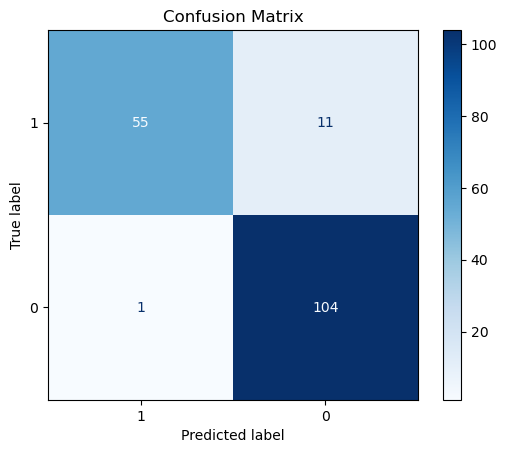

In [99]:
label = [1,0]
ConfusionMatrixDisplay(cm,display_labels=label).plot(cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()